In [1]:
import scipy.stats
import scipy.optimize

import numpy as np
import matplotlib.pyplot as plt
import uproot
import scipy.optimize
import matplotlib.gridspec as gridspec

import math

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'large',
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

energy_range = (0.03,2.03)
energy_bins = 25

def gauss_exp(x, n, mu, sigma, k):
    sigma = abs(sigma)
    condition = (x - mu) / sigma >= -k    
    y = np.copy(x)
    y[condition] = n * np.exp(-0.5 * ((x[condition] - mu) / sigma)**2)
    y[~condition] = n * np.exp(k**2 / 2 + k * ((x[~condition] - mu) / sigma))
#     print(x)
    return y

def get_function_max(f, *args):
    def func(x, *arg):
        return -f(x, *arg)
    return f(scipy.optimize.fmin(func, 0, args=args, disp=False)[0], *args)

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def mpv(array):
    if sum(array) < 5:
        return np.median(array)
    
    n_bins = energy_bins
    r = energy_range
    hist, bin_edges = np.histogram(array, bins=n_bins, range=r)
    
    bin_centers = [i*r[1]/n_bins-r[1]/(n_bins*2) for i in range(1,n_bins+1)]
    try:
        popt, pcov = scipy.optimize.curve_fit(gauss_exp, bin_centers, hist, maxfev=10000)
        return scipy.optimize.fmin(lambda x: -gauss_exp(x, *popt), 0)
    except RuntimeError:
        return np.median(array)
    
def fwhm(array):
    if sum(array) < 5:
        return np.std(array)

    n_bins = energy_bins
    r = energy_range
    hist, bin_edges = np.histogram(array, bins=n_bins, range=r)
    
    bin_centers = [i*r[1]/n_bins-r[1]/(n_bins*2) for i in range(1,n_bins+1)]

    try:
        popt, pcov = scipy.optimize.curve_fit(gauss_exp, bin_centers, hist, maxfev=10000)
        x_values = np.linspace(r[0], r[1], 1000)
        y_values = gauss_exp(np.linspace(r[0], r[1], 1000), *popt)
        try:
            x_max = scipy.optimize.fmin(lambda x: -gauss_exp(x, *popt), 0)
        except RuntimeError:
            x_max = np.median(array)
        y_max = find_nearest(y_values, gauss_exp(x_max, *popt))
        y_max_value = y_values[y_max]
        fwhm1 = find_nearest(y_values[:y_max], y_max_value/2)
        fwhm2 = find_nearest(y_values[y_max:], y_max_value/2)
        x_2 = x_values[y_max:][fwhm2]     
        x_1 = x_values[:y_max][fwhm1]
        return x_2-x_1
    except RuntimeError:
        return np.std(array)

In [14]:

folder = "nuselection"
tree = "SubRun"
filename = "root_files/v17/nue.root"
subrun_tree = uproot.open(filename)[folder][tree]
tree = uproot.open(filename)[folder]["NeutrinoSelectionFilter"]

df = tree.pandas.df(["elec_e", "shr_energy_tot_cali", "selected", "extra_energy_y", "shr_energy_tot", "nu_vtx_x", "isVtxInFiducial"])
df = df.query("selected==1 & elec_e > 0.03 & nu_vtx_x < 256 & nu_vtx_x > 128 & isVtxInFiducial == 1")

bin_means, bin_edges, binnumber = scipy.stats.binned_statistic(
    df["elec_e"], df["shr_energy_tot_cali"], statistic=mpv, range=(0.03,2.03), bins=10)

bin_stdev, bin_edges, binnumber = scipy.stats.binned_statistic(
    df["elec_e"], df["shr_energy_tot_cali"], statistic=fwhm, range=(0.03,2.03), bins=10)

Optimization terminated successfully.
         Current function value: -621.243393
         Iterations: 18
         Function evaluations: 36
Optimization terminated successfully.
         Current function value: -1240.083505
         Iterations: 20
         Function evaluations: 40
Optimization terminated successfully.
         Current function value: -949.725802
         Iterations: 22
         Function evaluations: 44
Optimization terminated successfully.
         Current function value: -727.328572
         Iterations: 23
         Function evaluations: 46
Optimization terminated successfully.
         Current function value: -581.371959
         Iterations: 24
         Function evaluations: 48
Optimization terminated successfully.
         Current function value: -383.792395
         Iterations: 24
         Function evaluations: 48
Optimization terminated successfully.
         Current function value: -326.979338
         Iterations: 25
         Function evaluations: 50
Optimization

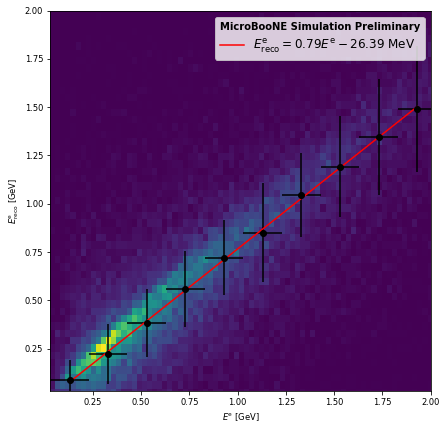

In [15]:
heatmap, xedges, yedges = np.histogram2d(df["elec_e"], df["shr_energy_tot_cali"], bins=200)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
fig, ax  = plt.subplots(figsize=(8,7))
ax.imshow(heatmap.T, extent=extent, origin='lower')
bin_centers = (bin_edges + (bin_edges[1]-bin_edges[0])/2)[:-1]
ax.errorbar(
    bin_centers,
    bin_means,
    xerr=0.1,
    yerr=bin_stdev/2,
    fmt='ko')

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(bin_centers, bin_means)
ax.plot(bin_centers, intercept + slope*bin_centers, 'r', label=r'$E^{\mathrm{e}}_{\mathrm{reco}}=%.2f E^{\mathrm{e}} %.2f$ MeV' % (slope, intercept*1000))
leg = ax.legend(title=r'MicroBooNE Simulation Preliminary')
leg._legend_box.align = "left"
plt.setp(leg.get_title(), fontweight='bold')

ax.set_xlim(0.03,2)
ax.set_xlabel(r"$E^{\mathrm{e}}$ [GeV]")
ax.set_ylabel(r"$E^{\mathrm{e}}_{\mathrm{reco}}$ [GeV]")
ax.set_ylim(0.03,2)

fig.savefig("plots/e_calib.pdf")

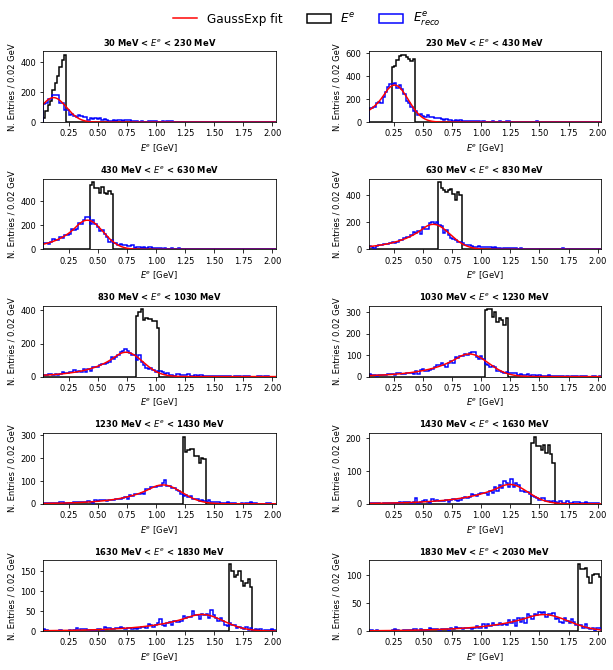

In [16]:
fig, ax = plt.subplots(figsize=(10, 10))
gs = gridspec.GridSpec(5, 2, hspace=0.8, wspace=0.4)

params = {
    'legend.fontsize': 'large',
    'axes.labelsize': 'small',
    'axes.titlesize': 'small',
    'xtick.labelsize': 'small',
    'ytick.labelsize': 'small'
}

pylab.rcParams.update(params)

for i in range(10):
    df_bin = df.query("%f < elec_e < %f" % (i * 0.2 + 0.03,
                                            (i + 1) * 0.2 + 0.03))
    label_true = ""
    label_reco = ""
    label_fit = ""
    if i == 0:
        label_true = r"$E^e$"
        label_reco = r"$E^e_{reco}$"
        label_fit = r'GaussExp fit'

    plt.subplot(gs[i]).hist(
        df_bin["elec_e"],
        linewidth=1.5,
        bins=100,
        range=(0.03, 2.03),
        histtype='step',
        color='k',
        label=label_true)

    hist, bin_edges, patches = plt.subplot(gs[i]).hist(
        df_bin["shr_energy_tot_cali"],
        linewidth=1.5,
        color='b',
        histtype='step',
        range=(0.03, 2.03),
        bins=100,
        label=label_reco)

    r = (0.03, 2.03)
    n_bins = 100

    bin_centers = [
        i * (r[1] - r[0]) / n_bins - (r[1] - r[0]) / (n_bins * 2) + r[0]
        for i in range(1, n_bins + 1)
    ]

    popt, pcov = scipy.optimize.curve_fit(
        gauss_exp, bin_centers, hist, maxfev=10000)
    x_values = np.linspace(r[0], r[1], 1000)
    y_values = gauss_exp(np.linspace(r[0], r[1], 1000), *popt)
    plt.plot(x_values, y_values, color='r', label=label_fit)
    plt.subplot(gs[i]).set_xlim(0.03, 2.03)
    plt.subplot(gs[i]).set_title(
        "%g MeV < $E^e$ < %g MeV" % ((i * 0.2 + 0.03) * 1000,
                                     ((i + 1) * 0.2 + 0.03) * 1000),
        fontweight='bold')
    plt.subplot(gs[i]).set_xlabel(r"$E^e$ [GeV]")
    plt.subplot(gs[i]).set_ylabel(r"N. Entries / 0.02 GeV")

fig.legend(loc='upper center', ncol=3, frameon=False)
fig.tight_layout()
fig.subplots_adjust(top=0.93)
fig.savefig("plots/e_spectra.pdf")

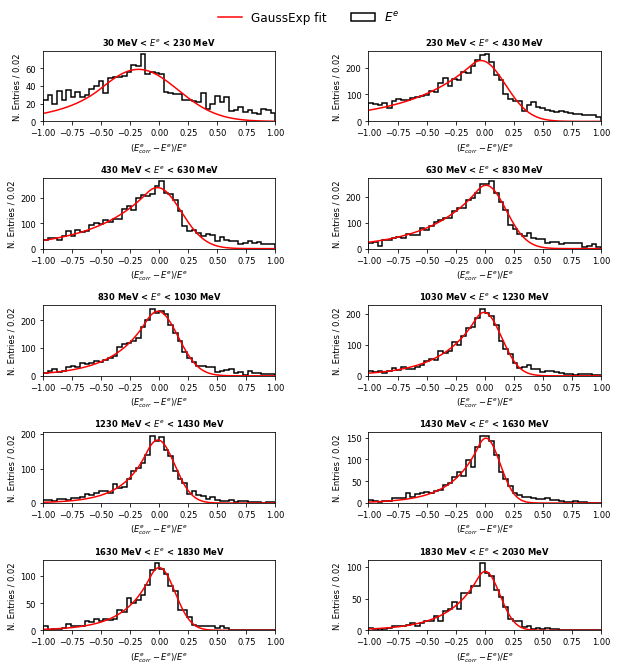

In [17]:
params = {
    'legend.fontsize': 'large',
    'axes.labelsize': 'small',
    'axes.titlesize': 'small',
    'xtick.labelsize': 'small',
    'ytick.labelsize': 'small'
}

pylab.rcParams.update(params)

fig_res, ax_res = plt.subplots(figsize=(10, 10))
gs_res = gridspec.GridSpec(5, 2, hspace=0.8, wspace=0.4)

sigma = np.array([])
sigma_err = np.array([])

for i in range(10):
    df_bin = df.query("%f < elec_e < %f" % (i * 0.2 + 0.03,
                                            (i + 1) * 0.2 + 0.03))
    label_true = ""
    label_reco = ""
    label_fit = ""
    if i == 0:
        label_true = r"$E^e$"
        label_reco = r"$E^e_{reco}$"
        label_fit = r'GaussExp fit'

    e_res = ((df_bin["shr_energy_tot_cali"] + intercept) / slope -
             df_bin["elec_e"]) / df_bin["elec_e"]
    n_bins = 50

    hist, bin_edges, patches = plt.subplot(gs_res[i]).hist(
        e_res,
        linewidth=1.5,
        bins=n_bins,
        range=(-1, 1),
        histtype='step',
        color='k',
        label=label_true)

    r = (-1, 1)

    bin_centers = np.array([
        i * (r[1] - r[0]) / len(hist) - (r[1] - r[0]) / (len(hist) * 2) + r[0]
        for i in range(1, len(hist) + 1)
    ])

    fit_range = np.logical_and(bin_centers < 0.5, bin_centers > -0.5)
    # n, mu, sigma, k
    popt, pcov = scipy.optimize.curve_fit(
        gauss_exp,
        bin_centers[fit_range],
        hist[fit_range],
        maxfev=100000,
        bounds=((0, -0.5, 0, 0), (np.inf, 0.5, np.inf, 1)))

    x_values = np.linspace(r[0], r[1], 1000)
    y_values = gauss_exp(np.linspace(r[0], r[1], 1000), *popt)
    sigma = np.append(sigma, popt[2])
    sigma_err = np.append(sigma_err, math.sqrt(np.diagonal(pcov)[2]))
    plt.plot(x_values, y_values, color='r', label=label_fit)
    plt.subplot(gs_res[i]).set_xlim(-1, 1)
    plt.subplot(gs_res[i]).set_title(
        "%g MeV < $E^e$ < %g MeV" % ((i * 0.2 + 0.03) * 1000,
                                     ((i + 1) * 0.2 + 0.03) * 1000),
        fontweight="bold")
    plt.subplot(gs_res[i]).set_xlabel(r"$(E^e_{corr}-E^e)/E^e$")
    plt.subplot(gs_res[i]).set_ylabel(r"N. Entries / 0.02")

fig_res.legend(loc='upper center', ncol=2, frameon=False)
fig_res.tight_layout()
fig_res.subplots_adjust(top=0.93)
fig_res.savefig("plots/res.pdf")

[0.3240116598246061, 0.19949148093099034, 0.19609778535668201, 0.17013662255409712, 0.16817579132094204, 0.15403503318239678, 0.14916217188922784, 0.12096653456283438, 0.13886400484769917, 0.13043198392552313]


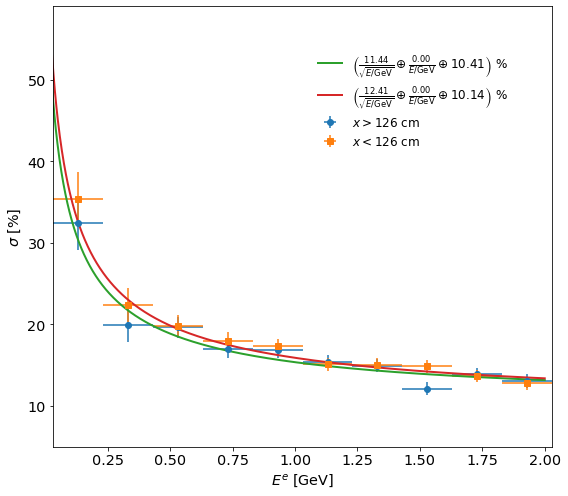

In [84]:
params = {
    'legend.fontsize': 'large',
    'axes.labelsize': 'x-large',
    'axes.titlesize': 'x-large',
    'xtick.labelsize': 'x-large',
    'ytick.labelsize': 'x-large'
}
pylab.rcParams.update(params)

fig, ax = plt.subplots(figsize=(8, 7))
x_centers = np.array([(i * 0.2 + 0.13) * 1000 for i in range(10)])


def res_fit(x, a, b, c):
    return np.sqrt((a / np.sqrt(x))**2 + (b / x)**2 + c**2)


cali_sigma = np.array([
    35.39586344, 21.89955796, 19.81002595, 17.83767035, 16.92886769,
    15.6121014, 15.09591906, 13.5825055, 13.82458992, 13.28548547
])

downstream_sigma = np.array([
    31.95557636479239, 19.409952137349315, 18.085034172331056,
    16.522095634523996, 15.419706331044889, 14.818296542475245,
    14.16043649038694, 13.884608957069336, 13.334489394066365,
    12.37837783084458
])

anode_sigma = np.array([
    0.3534023830741822, 0.22400111440976078, 0.19844497546636514,
    0.17913829495953398, 0.17307908255449303, 0.1506821070742761,
    0.150573835028876, 0.1482133469998717, 0.13612708798263196,
    0.1276068737677222
])

print(list(sigma))

ax.errorbar(
    x_centers / 1000,
    sigma * 100,
    xerr=0.1,
    yerr=sigma_err[0:] * 100,
    fmt='o',
    label=r"$x > 126$ cm")

ax.errorbar(
    x_centers / 1000,
    anode_sigma * 100,
    xerr=0.1,
    yerr=sigma_err[0:] * 100,
    fmt='s',
    label=r"$x < 126$ cm")

popt, pcov = scipy.optimize.curve_fit(
    res_fit,
    x_centers / 1000,
    sigma * 100,
    maxfev=10000,
    bounds=((0, 0, 0), (np.inf, np.inf, np.inf)),
    sigma=sigma_err * 100)

popt2, pcov2 = scipy.optimize.curve_fit(
    res_fit,
    x_centers / 1000,
    anode_sigma * 100,
    maxfev=10000,
    bounds=((0, 0, 0), (np.inf, np.inf, np.inf)),
    sigma=sigma_err * 100)

x_values = np.linspace(0, 2, 1000)
y_values = res_fit(np.linspace(0.03, 2.03, 1000), *popt)
y_values2 = res_fit(np.linspace(0.03, 2.03, 1000), *popt2)

plt.plot(
    x_values,
    y_values,
    linewidth=2,
    label=
    r'$\left(\frac{%.2f}{\sqrt{E / \mathrm{GeV}}}\oplus\frac{%.2f}{E / \mathrm{GeV}}\oplus %.2f\right)$ %%'
    % (popt[0], popt[1], popt[2]))

plt.plot(
    x_values,
    y_values2,
    linewidth=2,
    label=
    r'$\left(\frac{%.2f}{\sqrt{E / \mathrm{GeV}}}\oplus\frac{%.2f}{E / \mathrm{GeV}}\oplus %.2f\right)$ %%'
    % (popt2[0], popt2[1], popt2[2]))

ax.set_ylim(5, 59)
ax.set_xlim(0.03, 2.03)
ax.set_xlabel(r"$E^e$ [GeV]")
ax.set_ylabel(r"$\sigma$ [%]")

fig.legend(frameon=False, loc='best', bbox_to_anchor=(0.45, 0.45, 0.45, 0.45))
fig.tight_layout()
fig.savefig("plots/sigma_res.pdf")

In [ ]:
[ 130.  330.  530.  730.  930. 1130. 1330. 1530. 1730. 1930.] 